In [ ]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
# from transform import *
from transform_audio import *
# from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

DATA = "ravdess"
PITCH_NORMALIZED = False
TRIMMED = False
SUFFIX = ''
if PITCH_NORMALIZED:
    SUFFIX += '-pitch-normalized'
if TRIMMED:
    SUFFIX += '-trimmed'


data_dir  = os.path.join(ROOT_DIR, 'raw-data', DATA, f'full-{DATA}-audio-processed{SUFFIX}')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [2]:
import random
# could have been implemented more directly using random.sample, but keeping as is for reproducibility
def subsample_lists(file_list, file_names, p, seed):
    random.seed(seed)
    n_to_include = int(len(file_list) * p)
    random_filter = [True] * n_to_include + [False] * (len(file_list) - n_to_include)
    random.shuffle(random_filter)
    filtered_file_list = [path for path, include in zip(file_list, random_filter) if include]
    filtered_file_names = [name for name, include in zip(file_names, random_filter) if include]
    return filtered_file_list, filtered_file_names

filtered_file_list, filtered_file_names = subsample_lists(file_list, file_names, 0.3, 42)

In [3]:
transform_list(cwt_file, filtered_file_list, filtered_file_names, high_freq=24000, num_scales=100, affix='cwt-large')
os.rename('cwt-large_coefs.npz', 'cwt-large_coefs_30.npz')

Computing and exporting coefficients:   0%|          | 0/432 [00:00<?, ?it/s]

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [ ]:
ravdess_df = pd.read_csv(os.path.join(ROOT_DIR, "raw-data", DATA, f'full-{DATA}.csv'))

In [ ]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 8000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
# plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [ ]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=8000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        # plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [ ]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

In [ ]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')

## Frequency band grouping

In [2]:
bands = freq_band_groupings(
    coefs_npz_path='local/path/to/cwt_coefs_30.npz',
    subsample_every=12,
    batch_size=12,
    debug=True
)
bands

[0, 25) ~ [25, 50): presplit
  [0, 12) ~ [12, 25): 0.01367, 0.0
  [25, 37) ~ [37, 50): 0.23203, 0.0
    [25, 31) ~ [31, 37): 0.10239, 0.0
      [25, 28) ~ [28, 31): 0.04783, 0.0
      [31, 34) ~ [34, 37): 0.06452, 0.0
        [31, 32) ~ [32, 34): 0.02836, 0.0
        [34, 35) ~ [35, 37): 0.03642, 0.0
    [37, 43) ~ [43, 50): 0.15383, 0.0
      [37, 40) ~ [40, 43): 0.04812, 0.0
      [43, 46) ~ [46, 50): 0.13174, 0.0
        [43, 44) ~ [44, 46): 0.04310, 0.0
        [46, 48) ~ [48, 50): 0.10086, 0.0
          [46, 47) ~ [47, 48): 0.04212, 0.0
          [48, 49) ~ [49, 50): 0.08897, 0.0


[(0, 25),
 (25, 31),
 (31, 34),
 (34, 37),
 (37, 43),
 (43, 46),
 (46, 48),
 (48, 49),
 (49, 50)]

## Downsample with respect to non-"geometrically standardized" bands

In [ ]:
bands_05 = freq_band_groupings(
    'cwt-large_coefs_30.npz', # originally had 50 scales to start
    ks_threshold=0.05,
    batch_size=17,
    subsample_every=4,
    presplit_depth=2,
    cache=True,
    # debug=True
)

In [ ]:
bands_0375 = freq_band_groupings(
    'cwt-large_coefs_30.npz',
    ks_threshold=0.0375,
    subsample_every=5,
    presplit_depth=2,
    cache=True,
)

In [ ]:
bands_025 = freq_band_groupings(
    'cwt-large_coefs_30.npz',
    ks_threshold=0.025,
    subsample_every=5,
    presplit_depth=2,
    cache=True,
)

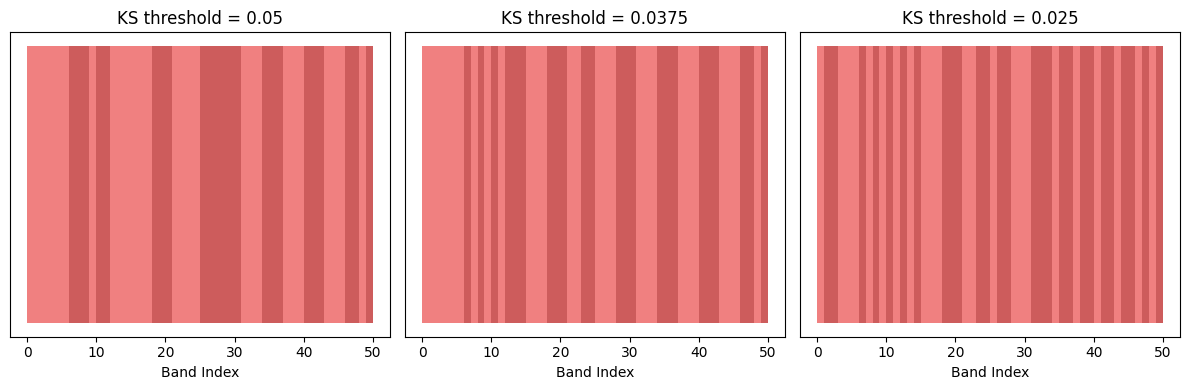

In [ ]:
colors = ['lightcoral', 'indianred']
def plot_bands(ax, bands, title):
    for i, (start, end) in enumerate(bands):
        color = colors[i % 2]
        ax.broken_barh([(start, end - start)], (0, 1), facecolors=color)
    ax.set_xlabel('Band Index')
    ax.set_yticks([])
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_bands(axs[0], bands_05, 'KS threshold = 0.05')
plot_bands(axs[1], bands_0375, 'KS threshold = 0.0375')
plot_bands(axs[2], bands_025, 'KS threshold = 0.025')
plt.tight_layout()
plt.show()

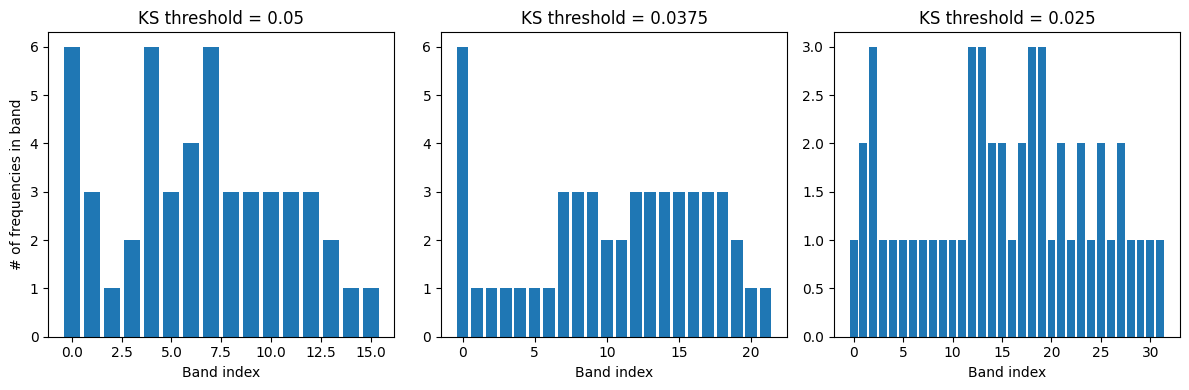

In [ ]:
# "widths" is synonymous with "counts" here
bands_to_widths = lambda bands: [band[1] - band[0] for band in bands]
widths_05, widths_0375, widths_025 = map(bands_to_widths, (bands_05, bands_0375, bands_025))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].bar(np.arange(len(bands_05)), widths_05)
axs[0].set_title('KS threshold = 0.05')
axs[1].bar(np.arange(len(bands_0375)), widths_0375)
axs[1].set_title('KS threshold = 0.0375')
axs[2].bar(np.arange(len(bands_025)), widths_025)
axs[2].set_title('KS threshold = 0.025')

axs[0].set_ylabel('# of frequencies in band')
for ax in axs:
    ax.set_xlabel('Band index')
plt.tight_layout()
plt.show()

In [ ]:
def cap_array(arr, cap):
    capped_arr = np.array(arr)
    capped_arr[capped_arr > cap] = cap
    return capped_arr

In [ ]:
cap_array(widths_0375, 2).sum(), cap_array(widths_05, 2).sum()

(np.int64(36), np.int64(29))

In [ ]:
def log_resample(start, end, n, last_band=False): # should be end-exclusive unless it's the last band
    return np.logspace(np.log10(start), np.log10(end), num=n, endpoint=last_band)

def downsample_scale(freqs, bands, cap):
    new_freq_lists = [log_resample(freqs[start], freqs[end], cap) if end - start > cap else freqs[start:end] for start, end in bands[:-1]]

    # handle last band separately
    start, end = bands[-1]
    new_freq_lists.append(log_resample(freqs[start], freqs[end - 1], cap, last_band=True) if end - start > cap else freqs[start:end])

    return np.concat(new_freq_lists)

In [ ]:
freqs = np.load('local/path/to/cwt-pn_freqs.npy')
len(freqs)

50

In [ ]:
new_freqs_0375_2 = downsample_scale(freqs, bands_0375, 2)
new_freqs_05_2 = downsample_scale(freqs, bands_05, 2)

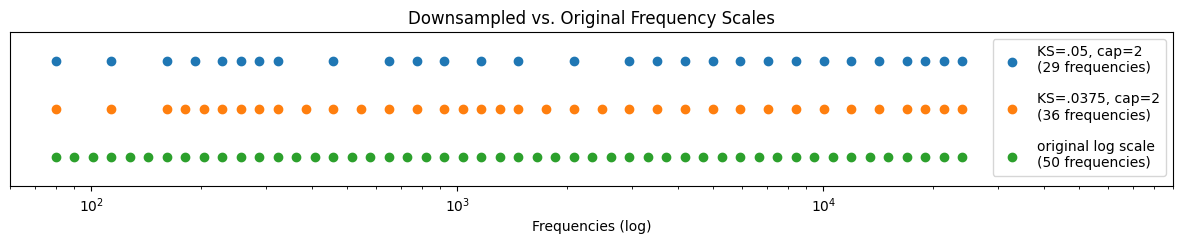

In [ ]:
plt.figure(figsize=(15, 2))
plt.scatter(new_freqs_05_2, 2 * np.ones_like(new_freqs_05_2), label=f'KS=.05, cap=2\n({len(new_freqs_05_2)} frequencies)')
plt.scatter(new_freqs_0375_2, np.ones_like(new_freqs_0375_2), label=f'KS=.0375, cap=2\n({len(new_freqs_0375_2)} frequencies)')
plt.scatter(freqs, np.zeros_like(freqs), label=f'original log scale\n({len(freqs)} frequencies)')
plt.xscale('log')
plt.ylim((-.6, 2.6))
plt.xlim((60, 90_000))
plt.yticks([])
plt.xlabel('Frequencies (log)')
plt.title('Downsampled vs. Original Frequency Scales')
plt.legend(labelspacing=1.25)
plt.show()

In [14]:
def cwt_file_custom(file_path, frequencies, wavelet='cmor1.5-1.0', visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(file_path)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal.astype('float32'), scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(np.arange(len(signal)) / rate, freqs, np.abs(coefs), norm='log', cmap='inferno', vmin=100)
        plt.colorbar(label='Magnitude')
        plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs
cwt_file_custom.affix = 'cwt'

In [16]:
transform_list(cwt_file_custom, file_list, file_names, new_freqs_0375_2, affix='cwt-pn')

Computing and exporting coefficients:   0%|          | 0/1440 [00:00<?, ?it/s]

## Geometrically standardize before applying downsampling

In [ ]:
bands = freq_band_groupings(
    'cwt-large_coefs_30.npz',
    ks_threshold=0.05,
    batch_size=20,
    subsample_every=5,
    presplit_depth=2,
    cache=True,
    debug=True
)

[0, 50) ~ [50, 100): presplit
  [0, 25) ~ [25, 50): presplit
    [0, 12) ~ [12, 25): 0.12772, 0.0
      [0, 6) ~ [6, 12): 0.03275, 0.0
      [12, 18) ~ [18, 25): 0.16882, 0.0
        [12, 15) ~ [15, 18): 0.05626, 0.0
          [12, 13) ~ [13, 15): 0.01634, 0.0
          [15, 16) ~ [16, 18): 0.03894, 0.0
        [18, 21) ~ [21, 25): 0.08478, 0.0
          [18, 19) ~ [19, 21): 0.05585, 0.0
            [19, 20) ~ [20, 21): 0.03487, 0.0
          [21, 23) ~ [23, 25): 0.02399, 0.0
    [25, 37) ~ [37, 50): 0.06581, 0.0
      [25, 31) ~ [31, 37): 0.02698, 0.0
      [37, 43) ~ [43, 50): 0.05712, 0.0
        [37, 40) ~ [40, 43): 0.01886, 0.0
        [43, 46) ~ [46, 50): 0.03940, 0.0
  [50, 75) ~ [75, 100): presplit
    [50, 62) ~ [62, 75): 0.08697, 0.0
      [50, 56) ~ [56, 62): 0.04134, 0.0
      [62, 68) ~ [68, 75): 0.05586, 0.0
        [62, 65) ~ [65, 68): 0.02372, 0.0
        [68, 71) ~ [71, 75): 0.03286, 0.0
    [75, 87) ~ [87, 100): 0.14029, 0.0
      [75, 81) ~ [81, 87): 0.07054, 0.0
   

In [ ]:
freqs = np.load('cwt-large_freqs.npy')

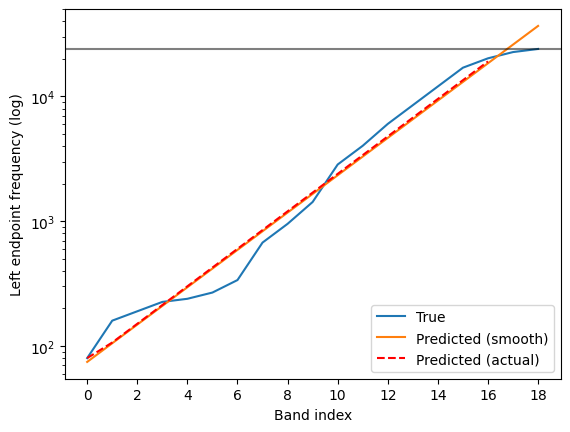

In [ ]:
new_bands = geometric_endpoint_bands(bands, freqs, True)

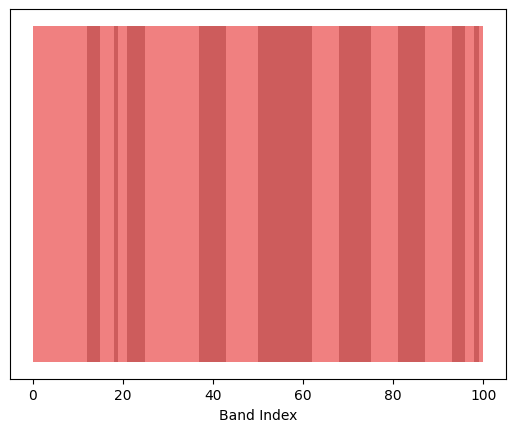

In [ ]:
colors = ['lightcoral', 'indianred']
for i, (start, end) in enumerate(bands):
    plt.broken_barh([(start, end - start)], (0, 1), facecolors=colors[i%2])
plt.xlabel('Band Index')
plt.yticks([])
plt.show()

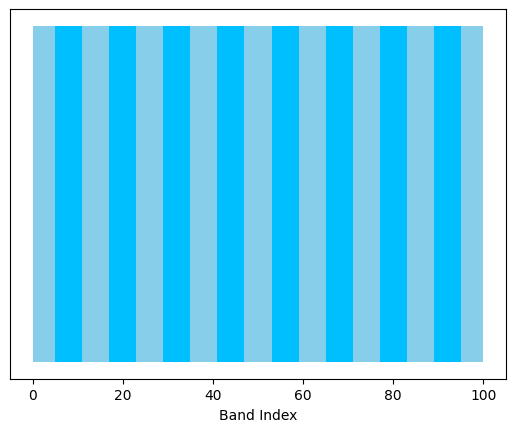

In [ ]:
colors = ['skyblue', 'deepskyblue']
for i, (start, end) in enumerate(new_bands):
    plt.broken_barh([(start, end - start)], (0, 1), facecolors=colors[i%2])
plt.xlabel('Band Index')
plt.yticks([])
plt.show()

In [ ]:
# duplicated from above

def log_resample(start, end, n, last_band=False): # should be end-exclusive unless it's the last band
    return np.logspace(np.log10(start), np.log10(end), num=n, endpoint=last_band)

def downsample_scale(freqs, bands, cap):
    new_freq_lists = [log_resample(freqs[start], freqs[end], cap) if end - start > cap else freqs[start:end] for start, end in bands[:-1]]

    # handle last band separately
    start, end = bands[-1]
    new_freq_lists.append(log_resample(freqs[start], freqs[end - 1], cap, last_band=True) if end - start > cap else freqs[start:end])

    return np.concat(new_freq_lists)

In [ ]:
# with a cap of n, the resulting scale will have n * len(new_bands) frequencies
len(new_bands)

17

In [ ]:
downsampled_freqs = downsample_scale(freqs, new_bands, 2)
len(downsampled_freqs)

34

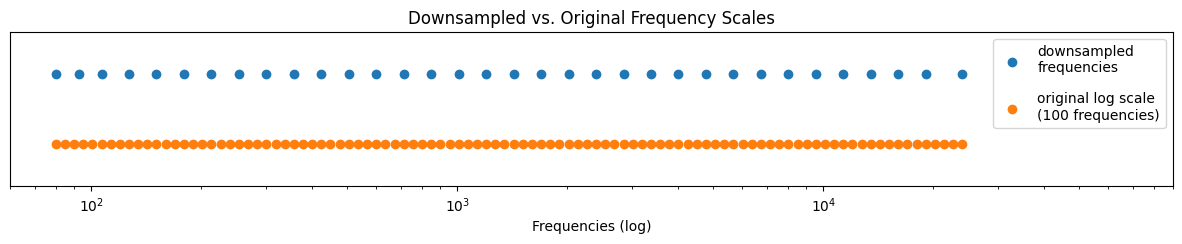

In [ ]:
plt.figure(figsize=(15, 2))
plt.scatter(downsampled_freqs, np.ones_like(downsampled_freqs), label=f'downsampled\nfrequencies')
plt.scatter(freqs, np.zeros_like(freqs), label=f'original log scale\n({len(freqs)} frequencies)')
plt.xscale('log')
plt.ylim((-.6, 1.6))
plt.xlim((60, 90_000))
plt.yticks([])
plt.xlabel('Frequencies (log)')
plt.title('Downsampled vs. Original Frequency Scales')
plt.legend(labelspacing=1.25)
plt.show()

Concern: This is nearly equivalent to simply generating a less dense logarithmic frequency scale from the start (i.e., using a smaller num_scales parameter). The point of performing downsampling on the raw bands was that they gave the most raw information about where resolution is needed. If we're going to downsample using "regularized" bands, we might as well skip the banding calculations entirely.

In [2]:
transform_list(cwt_file, file_list, file_names, num_scales=32, high_freq=20000, affix='cwt-small')

Computing and exporting coefficients:   0%|          | 0/1440 [00:00<?, ?it/s]